# WellOps  
## Model Explainability using SHAP


The objective of this notebook is to explain individual burnout risk predictions using SHAP (SHapley Additive exPlanations).

Explainability is critical in WellOps to ensure transparency, trust, and ethical use of AI-driven recommendations.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

import shap

In [5]:
np.random.seed(42)

n_employees = 200
n_weeks = 24
data = []

for emp_id in range(n_employees):
    role = np.random.choice(["Engineer", "Analyst", "Manager"])
    base_hours = np.random.normal(40, 5)

    for week in range(n_weeks):
        weekly_hours = max(30, base_hours + np.random.normal(0, 6))
        tasks_assigned = max(1, int(np.random.normal(10, 3)))
        overtime_hours = max(0, weekly_hours - 40)
        task_switches = max(1, int(np.random.normal(6, 2)))
        stress_indicator = np.clip(np.random.normal(0.5, 0.15), 0, 1)

        data.append([
            emp_id, week, role, weekly_hours,
            tasks_assigned, overtime_hours,
            task_switches, stress_indicator
        ])

df = pd.DataFrame(data, columns=[
    "employee_id", "week_id", "role",
    "weekly_hours", "tasks_assigned",
    "overtime_hours", "task_switches",
    "stress_indicator"
])

In [6]:
epsilon = 1e-6

df["workload_intensity"] = df["weekly_hours"] / (df["tasks_assigned"] + epsilon)
df["overtime_ratio"] = df["overtime_hours"] / (df["weekly_hours"] + epsilon)
df["switch_pressure"] = df["task_switches"] / (df["tasks_assigned"] + epsilon)

df["rolling_hours_mean"] = (
    df.groupby("employee_id")["weekly_hours"]
    .transform(lambda x: x.rolling(4, min_periods=1).mean())
)

df["rolling_overtime_sum"] = (
    df.groupby("employee_id")["overtime_hours"]
    .transform(lambda x: x.rolling(4, min_periods=1).sum())
)

df["burnout_score"] = (
    0.35 * df["overtime_ratio"] +
    0.25 * df["stress_indicator"] +
    0.20 * df["workload_intensity"] +
    0.20 * df["switch_pressure"]
)

df["burnout_score"] = np.clip(df["burnout_score"], 0, 1)

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)


In [7]:
df_encoded = pd.get_dummies(df, columns=["role"], drop_first=True)

features = df_encoded.drop(
    columns=["employee_id", "week_id", "burnout_score"]
)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

y = df_encoded["burnout_score"]

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


In [8]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    max_depth=8,
    min_samples_split=10
)

rf_model.fit(X_train, y_train)


,n_estimators,200
,criterion,'squared_error'
,max_depth,8
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [9]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)


C:\Users\krush\AppData\Local\Temp\ipykernel_28132\316835681.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


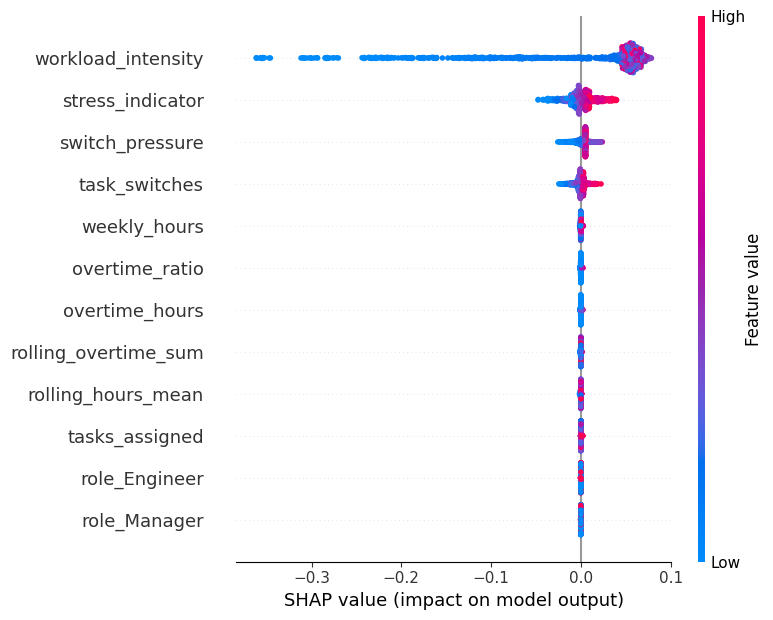

In [10]:
shap.summary_plot(
    shap_values,
    X_test,
    feature_names=features.columns
)


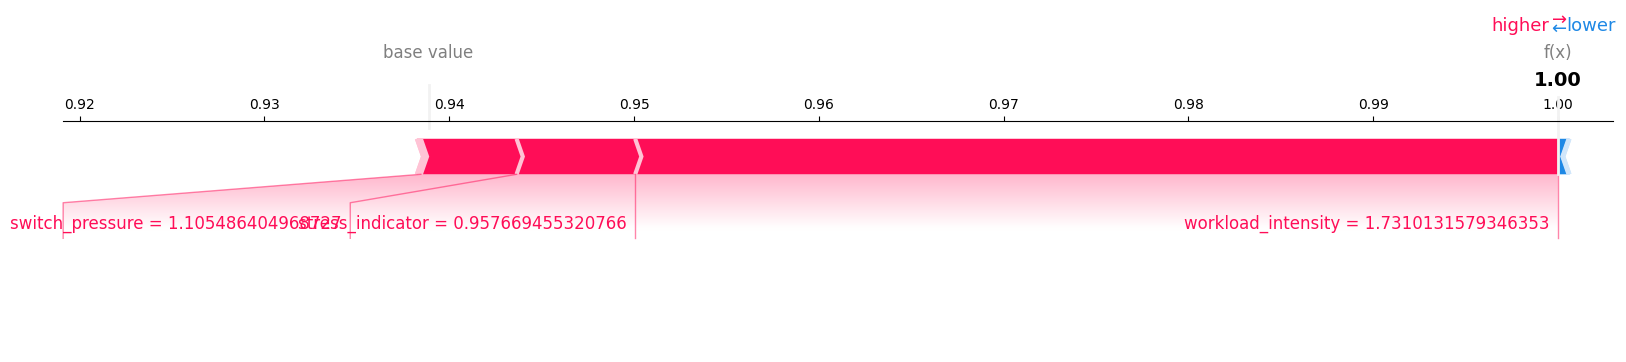

In [11]:
sample_idx = 0

shap.force_plot(
    explainer.expected_value,
    shap_values[sample_idx],
    X_test[sample_idx],
    feature_names=features.columns,
    matplotlib=True
)


### Explainability Insights

SHAP analysis confirms that overtime-related features, workload intensity, and stress indicators are the primary contributors to burnout risk.

This aligns with domain expectations and validates the model’s reasoning process.

Explainability ensures that predictions are transparent and suitable for decision-support rather than automated enforcement.
